In [5]:
import pandas as pd
import os
import random
import networkx as nx
import collections
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
import copy
%matplotlib notebook

### 依旧是读取数据

In [6]:
def datelist(beginDate, endDate):
    # beginDate, endDate是形如‘20160601’的字符串或datetime格式
    date_l=[datetime.strftime(x,'%Y%m%d') for x in list(pd.date_range(start=beginDate, end=endDate))]
    return date_l

In [7]:
dates = datelist('20200101', '2020012')

ValueError: could not convert string to Timestamp

In [ ]:
csvdata = []
for name in dates:
    with open('2020/%s.export.CSV'%name,'r') as f:
        lines = f.readlines()
        for i in range(len(lines)):
            lines[i]= lines[i].split('\n')[0]
            lines[i]= lines[i].split('\t')
            csvdata.append(lines[i])


In [ ]:
title = ['索引','日期','发生年月','发生年','时间节点百分比', # 事件的全局符号马 EVENT AND DATE ATTRIBUTES
         '信息码1','参与1名称','参与1国家','参与1组织','参与1民族','参与1宗教','参与1额外宗教','参与1角色','参与1额外角色','参与1额外角色',# 参与者信息 ACTOR ATTRIBUTES 
         '信息码2','参与2名称','参与2国家','参与2组织','参与2民族','参与2宗教','参与2额外宗教','参与2角色','参与2额外角色','参与2额外角色',
         '是否根节点','参与者1对2的行为','三级分类','根节点','事件类型','事件的潜在影响(无细节)','提及次数','数据源','文章数','舆论评分',# 事件的属性 EVENT ACTION ATTRIBUTES
         '参与1Geo类型','参与1地理全称','参与1国家编号','参与1全球编码','参与1纬度','参与1经度','参与1GNS标识',# 地理信息  EVENT GEOGRAPHY
         '参与2Geo类型','参与2地理全称','参与2国家编号','参与2全球编码','参与2纬度','参与2经度','参与2GNS标识',
         '发生地Geo类型','发生地地理全称','发生地国家编号','发生地全球编码','发生地纬度','发生地经度','发生地GNS标识' ,
         '加入数据库的日期','新闻URL' # 信息记录  DATA MANAGEMENT FIELDS
        ]

In [ ]:
csvdata = pd.DataFrame(lines,columns=title) 

In [ ]:
csvdata.shape

#### 获取需要使用的数据

In [ ]:
title_in_use = ['参与1国家','参与2国家', '事件类型']
data_in_use = csvdata[title_in_use]

In [ ]:
# 保留字段完整的数据
data_split = data_in_use[(data_in_use['参与1国家']!='') & (data_in_use['参与2国家']!='')]

In [ ]:
data_split.head()

### 开始统计

In [ ]:
counter = {}
for index, row in data_split.iterrows():
    if row['参与1国家'] not in counter.keys():
        counter[row['参与1国家']] = {}
    if row['参与2国家'] not in counter[row['参与1国家']].keys():
        counter[row['参与1国家']][row['参与2国家']] = 0
    counter[row['参与1国家']][row['参与2国家']] += 1
len(counter)  

In [ ]:
# 剔除没有连接的点
counter_filter = copy.copy(counter)
for key,values in counter.items():
    if len(values) < 2:
        counter_filter.pop(key)
print(len(counter),len(counter_filter))

In [ ]:
G = nx.Graph()

In [ ]:
for country1, country2_dic in counter_filter.items():
    for country2, value in country2_dic.items():
        G.add_edge(country1, country2, weight=value )

### 数据计算

In [ ]:
# 点的数量
G.number_of_nodes()

In [ ]:
# 边的数量
G.number_of_edges()

In [ ]:
# 平均相邻度计算
average_neighbor_dic = nx.average_neighbor_degree(G,source ='out',target ='out')
sum(average_neighbor_dic.values())/len(average_neighbor_dic.keys())

In [ ]:
H = nx.Graph(G)
# 最短平均路径长度
nx.average_shortest_path_length(G)

In [204]:
G.is_directed()

True

In [8]:
nx.draw_networkx(G,node_color='pink')

NameError: name 'G' is not defined

In [97]:
average_neighbor_dic = nx.average_neighbor_degree(G,source ='out',target ='out')

In [99]:
sum(average_neighbor_dic.values())/len(average_neighbor_dic.keys())

31.558537218874122

In [91]:
X=set(list(counter.keys()))
bipartite.density(G,X)

1.06

In [100]:
H = nx.Graph(G)

In [102]:
average_neighbor_dic2 = nx.average_neighbor_degree(H,source ='out',target ='out')

In [103]:
sum(average_neighbor_dic2.values())/len(average_neighbor_dic2.keys())

35.63788703122901

In [104]:
X=set(list(counter.keys()))
bipartite.density(H,X)

1.3805714285714286

In [123]:
G_small = nx.DiGraph()
G_small.add_edge('CHN', 'USA', weight=counter["CHN"]["USA"] )
G_small.add_edge("USA", "CHN", weight=counter["USA"]["CHN"]  )
G_small.add_edge("CHN", "JPN", weight=counter["CHN"]["JPN"] )

In [124]:
counter["CHN"]["JPN"]

41

In [125]:
for node in G_small:
    print(node)

CHN
USA
JPN


In [152]:
#plt.figure()
pos_nodes = nx.spring_layout(G_small)
#nx.draw(G_small, pos_nodes, with_labels=True)

pos_attrs = {}
for node, coords in pos_nodes.items():
    pos_attrs[node] = (coords[0], coords[1] + 0.08)

node_attrs = nx.get_node_attributes(G, 'type')
custom_node_attrs = {}

custom_node_attrs['CHN'] = str(counter["CHN"]["USA"])
custom_node_attrs['USA'] = str(counter["USA"]["CHN"])
custom_node_attrs['JPN'] = str(counter["CHN"]["JPN"])
nx.draw_networkx_labels(G_small, pos_attrs, labels=custom_node_attrs)

{'CHN': Text(0.1849186002981191, 0.19861376434814643, '91'),
 'USA': Text(0.8150813997018804, 0.6028291600339627, '130'),
 'JPN': Text(-1.0, -0.5614429243821092, '41')}

<IPython.core.display.Javascript object>


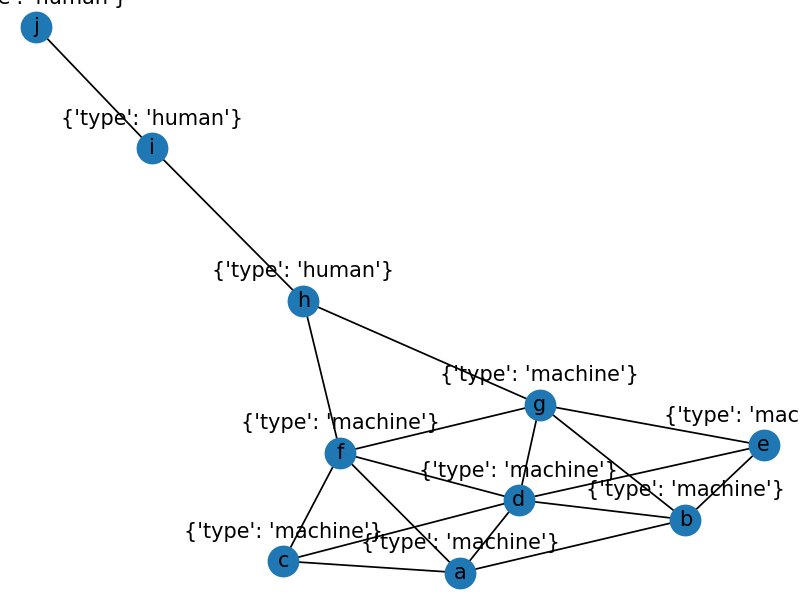

In [163]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from(['a', 'b', 'c', 'd', 'e', 'f', 'g'], type = 'machine')
G.add_nodes_from(['h', 'i', 'j'], type = 'human')
G.add_edges_from([('a', 'c'), ('a', 'b'), ('a', 'd'), ('a', 'f'), ('b', 'd'), ('b', 'e'), ('b', 'g'), ('c', 'f'), ('c', 'd'), ('d', 'f'), ('d', 'e'), ('d', 'g'), ('e', 'g'), ('f', 'g'), ('f', 'h'), ('g', 'h'), ('h', 'i'), ('i', 'j')])

plt.figure()
pos_nodes = nx.spring_layout(G)
nx.draw(G, pos_nodes, with_labels=True)

pos_attrs = {}
for node, coords in pos_nodes.items():
    pos_attrs[node] = (coords[0], coords[1] + 0.08)

node_attrs = nx.get_node_attributes(G, 'type')
custom_node_attrs = {}
for node, attr in node_attrs.items():
    custom_node_attrs[node] = "{'type': '" + attr + "'}"

nx.draw_networkx_labels(G, pos_attrs, labels=custom_node_attrs)
plt.show()

In [145]:
plt.savefig("path.png")

In [153]:
nx.average_shortest_path_length(G)

1.9777777777777779